In [1]:
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
import calendar
from pandas import DataFrame
import glob

import warnings
warnings.filterwarnings(action='ignore')

# fields names
ped_level= 'ped_level'


### get time features and ped level from moovit data

In [2]:

cols_to_use =['Period','W', 'ID', 'morning', 'noon', 'afternoon','night']
moovit_data = [gpd.read_file(x)[cols_to_use] for x in glob.glob(r'output/moovit/*.shp') ]

In [3]:
# Calculate season predictor
month_name = [x for x in calendar.month_abbr]
for moovit_file in moovit_data:
    month = month_name.index(moovit_file['Period'][0][:3].lower().capitalize())
    if month in [12, 1, 2]:
        season = 1
    elif month in [3, 4, 5]:
        season = 2
    elif month in [6, 7, 8]:
        season = 3
    else:
        season = 0
    moovit_file['season'] =  season
    # Encode W columns
    moovit_file['day'] = 0 if moovit_file['W'][0]=='WeekDay'else 1
moovit_data

[     Period        W    ID  morning  noon  afternoon  night  season  day
 0     APR21  WeekDay     0        1     0          2      0       2    0
 1     APR21  WeekDay     1        4     4          4      3       2    0
 2     APR21  WeekDay     2        4     4          4      3       2    0
 3     APR21  WeekDay     3        1     9          0      2       2    0
 4     APR21  WeekDay     4        0     0          9      1       2    0
 ...     ...      ...   ...      ...   ...        ...    ...     ...  ...
 8536  APR21  WeekDay  8760        3     2          1      0       2    0
 8537  APR21  WeekDay  8761        0     0          0      0       2    0
 8538  APR21  WeekDay  8762        4     4          4      3       2    0
 8539  APR21  WeekDay  8763        2     3          2      3       2    0
 8540  APR21  WeekDay  8764        3     4          2      3       2    0
 
 [8541 rows x 9 columns],
      Period        W    ID  morning  noon  afternoon  night  season  day
 0     APR

In [33]:
# flat the data so each ped level would be in a new row
def rearrange_data(row):
    r"""
    :param row:
    :return:
    """
    id= row['ID']
    def add_row(day_part,ped_level_val):
        r"""
        if the ped level is not 9 add new line to the list with ID, day part and ped level
        :param day_part:
        :param ped_level:
        :return:
        """
        data_for_ml.append([id,day_part,row['season'],row['day'],ped_level_val])
    [add_row(x,row[x+3]) for x in range(4)]

data_for_ml = []
_ = [moovit_file.apply(rearrange_data,axis=1) for moovit_file in moovit_data]
ml_data = DataFrame(data_for_ml,columns=['ID','day part','season','day',ped_level])
ml_data = ml_data[ml_data['ped_level']<9]
ml_data.to_csv('ml/model_data.csv')
ml_data

,ID,day part,season,day,ped_level
0,0,0,2,0,1
1,0,1,2,0,0
2,0,2,2,0,2
3,0,3,2,0,0
4,1,0,2,0,4
...,...,...,...,...,...
532538,8763,2,0,1,0
532539,8763,3,0,1,1
532540,8764,0,0,1,0
532541,8764,1,0,1,2


In [34]:
ml_data['ped_level'].unique()

array([1, 0, 2, 4, 3], dtype=int64)

In [35]:
# join street attributes to the rest of the data (lable and time)
network_data = gpd.read_file(r'output/streets_elements/streets_elements.shp')

result = ml_data.set_index('ID').join(network_data, how='inner')
ml_result = result.drop(columns=['oidrechov','length','geometry'])
# move column 'B' to the end of the dataframe
col_to_move = ml_result.pop(ped_level)
ml_df = ml_result.assign(ped_level=col_to_move)
ml_df

,day part,season,day,buildings,businesses,educationa,Health_ser,Leisure_am,Playground,Sport_faci,synagogues,bus_statio,lighting,trees,bike_trail,parks,density,ped_level
0,0,2,0,12.580000,0.000000,8,1,0,7,3,4,0.030481,0.060961,0.000000,0,12,3.3,1
0,1,2,0,12.580000,0.000000,8,1,0,7,3,4,0.030481,0.060961,0.000000,0,12,3.3,0
0,2,2,0,12.580000,0.000000,8,1,0,7,3,4,0.030481,0.060961,0.000000,0,12,3.3,2
0,3,2,0,12.580000,0.000000,8,1,0,7,3,4,0.030481,0.060961,0.000000,0,12,3.3,0
0,0,2,1,12.580000,0.000000,8,1,0,7,3,4,0.030481,0.060961,0.000000,0,12,3.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8750,3,0,0,16.378889,0.001021,4,2,0,2,7,0,0.006125,0.042872,0.103097,1,6,1.4,4
8750,0,0,1,16.378889,0.001021,4,2,0,2,7,0,0.006125,0.042872,0.103097,1,6,1.4,4
8750,1,0,1,16.378889,0.001021,4,2,0,2,7,0,0.006125,0.042872,0.103097,1,6,1.4,4
8750,2,0,1,16.378889,0.001021,4,2,0,2,7,0,0.006125,0.042872,0.103097,1,6,1.4,4


In [36]:
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# clf = DecisionTreeClassifier(random_state=0)
data_feature = ml_df.drop(columns=[ped_level])
x_tree = data_feature.to_numpy()
y_tree = ml_df[ped_level].to_numpy()

# dt = clf.fit(x_tree, y_tree)
# model = SelectFromModel(dt, prefit=True)
# X_new = model.transform(x_tree)


In [37]:
# Cross Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV

In [22]:
# Random Forest Tree
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x_tree, y_tree, test_size=0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
param_grid = {"n_estimators": [300],'criterion':['gini', 'entropy', 'log_loss']}
clf = RandomForestClassifier(random_state=0)
search = GridSearchCV(clf, param_grid,n_jobs=-1).fit(X_train, y_train)

# Confusion Matrix
y_pred =search.predict(X_test)
cm= confusion_matrix(y_test,y_pred)

search.best_score_

nan

In [21]:
search.best_params_

{'criterion': 'gini', 'n_estimators': 200}

In [38]:
# Decision Tree
X_train, X_test, y_train, y_test = train_test_split(x_tree, y_tree, test_size=0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
param_grid = {"criterion": ["gini", "entropy"],"splitter": ['best', 'random'],'max_features':['auto','sqrt','log2',None]}
clf = DecisionTreeClassifier(random_state=0)
search =GridSearchCV(clf, param_grid,n_jobs=-1).fit(X_train, y_train)

# Confusion Matrix
y_pred =search.predict(X_test)
cm= confusion_matrix(y_test,y_pred)
cm

array([[13501,  5615,  2301,   619,   108],
       [ 6274,  6305,  4236,  1324,   252],
       [ 2640,  4616,  6993,  4029,   691],
       [  773,  1599,  4344,  7181,  3114],
       [  132,   250,   864,  3390, 13609]], dtype=int64)

In [39]:
search.best_score_

0.4950031658927818

In [40]:
search.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}

In [41]:
dt = DecisionTreeClassifier(random_state=0,criterion='entropy', max_features='auto', splitter='best').fit(x_tree, y_tree)
dt.feature_importances_.round(3)*100

array([20.2, 22.8,  4.2,  9.1,  3.5,  3.7,  2.8,  1.9,  2.6,  3.2,  3.5,
        1.2,  6.6,  4. ,  0.7,  5.4,  4.6])

In [42]:
features_cols = data_feature.columns
new_df = DataFrame(data={'feature_importances':dt.feature_importances_.round(3)*100,'features_name':data_feature.columns}).sort_values('feature_importances',ascending=0)
new_df

,feature_importances,features_name
1,22.8,season
0,20.2,day part
3,9.1,buildings
12,6.6,lighting
15,5.4,parks
16,4.6,density
2,4.2,day
13,4.0,trees
5,3.7,educationa
10,3.5,synagogues


([<matplotlib.patches.Wedge at 0x202e750d4b0>,
 [Text(-0.72224429279901, 0.8296765523499252, 'season'),
  Text(-0.9672479782895214, -0.523861955571154, 'day part'),
  Text(-0.1686638958988192, -1.0869924057785465, 'buildings'),
  Text(0.3661014838248676, -1.0372895948293468, 'lighting'),
  Text(0.7222443219289815, -0.8296765269919031, 'parks'),
  Text(0.9432793180513073, -0.5658834934301062, 'density'),
  Text(1.0619198003794401, -0.2869256655687847, 'day'),
  Text(1.0999782868537455, -0.006911472368401495, 'trees'),
  Text(1.069606916043805, 0.25678988521992174, 'educationa'),
  Text(0.984770219077013, 0.49013020272067687, 'synagogues'),
  Text(0.8541351716785452, 0.6931472487874868, 'businesses'),
  Text(0.6904605024706945, 0.8563085276510543, 'Sport_faci'),
  Text(0.5177743295163002, 0.9705203468727206, 'Health_ser'),
  Text(0.3464851836925749, 1.044005755482949, 'Playground'),
  Text(0.19592683839371042, 1.082410584758411, 'Leisure_am'),
  Text(0.08974969381873858, 1.09633251911062

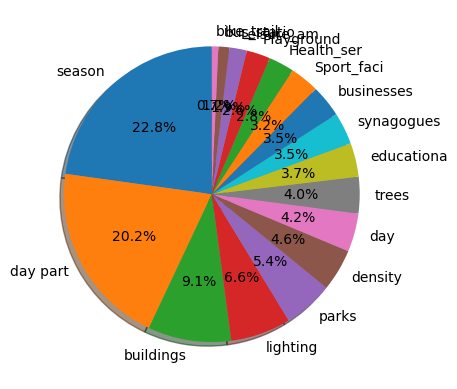

In [43]:

fig1, ax1 = plt.subplots()
ax1.pie(new_df['feature_importances'], labels=new_df['features_name'], autopct='%1.1f%%',
        shadow=True, startangle=90)

In [ ]:
fig, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 20), dpi=500)
tree.plot_tree(dt,
               feature_names= features_cols,
               filled=True,
               rounded= True
               )
fig.savefig('tree_5.pdf')